## RAPP Evaluation

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
import seaborn as sns
from datetime import datetime

## Function defiition
- Input dataframe (df)
- Sum list (sl) – A list of variables names that need to be summed
- Mean list (ml) – A list of variables that need to be averaged
- Max list (mxl) – A list of variables for which the max need to be determined
- Min list (mnl) – A list of variables for which the min needs to be determined
- Group by list (gbyl) – The group by variables

In [3]:
AutoData = pd.read_csv("D:\\Box Sync\\University of Texas\\Summer Intern\\RAPP\\imports-85.txt",sep=",",header= None)
AutoData.columns = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
print(AutoData.head())
AutoData.describe()

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compressi

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [3]:
def aggregate_df(df,sl,ml,mxl,mnl,bgyl):
    result=[]
    result.append(df.groupby(gbyl)[sl].apply(lambda s:s.max()).add_suffix('_sum'))
    result.append(df.groupby(gbyl)[ml].apply(lambda s:s.mean()).add_suffix('_mean'))
    result.append(df.groupby(gbyl)[mxl].apply(lambda s:s.max()).add_suffix('_max'))
    result.append(df.groupby(gbyl)[mnl].apply(lambda s:s.min()).add_suffix('_min'))
    return result

#### Test Cases

In [4]:
sl = ['wheel-base','length']
gbyl = ['make','fuel-type']
ml = ['wheel-base','length']
mxl = ['wheel-base','length']
mnl = ['wheel-base','length']
result = aggregate_df(AutoData,sl,ml,mxl,mnl,gbyl)
#result
result

[                         wheel-base_sum  length_sum
 make          fuel-type                            
 alfa-romero   gas                  94.5       171.2
 audi          gas                 105.8       192.7
 bmw           gas                 110.0       197.0
 chevrolet     gas                  94.5       158.8
 dodge         gas                 103.3       174.6
 honda         gas                  96.5       175.4
 isuzu         gas                  96.0       172.6
 jaguar        gas                 113.0       199.6
 mazda         diesel              104.9       177.8
               gas                 104.9       177.8
 mercedes-benz diesel              115.6       202.6
               gas                 120.9       208.1
 mercury       gas                 102.7       178.4
 mitsubishi    gas                  96.3       173.2
 nissan        diesel               94.5       165.3
               gas                 100.4       184.6
 peugot        diesel              114.2      

## Classificaiton Model
Use the data set located at:
https://rappagency.box.com/v/intern-pgm-analytics-binary


To build a binary classification model.  Assume that all the columns apart from the target can be used as features to predict the target. 

Carry out the following steps and answer the questions as you go along.
- Build a predictive model that best fits the data (according to you). What is the evidence that the model hasn’t under or over fitted?
- What was your choice of evaluation metric and why?
- Justify your choice of your learning algorithm. What are the pros and cons of the algorithm you chose.

In [4]:
RawData = pd.read_csv("D:\\Box Sync\\University of Texas\\Summer Intern\\RAPP\\Binary_classification\\binary_classification_ds.csv")
RawData.describe()

,id,col_24,col_263,col_264,col_214,col_39,col_280,col_140,col_328,col_309,...,col_217,col_262,col_53,col_17,col_259,col_247,col_287,col_990,col_991,target
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,249924.77968,0.524521,0.000040,0.060380,0.013480,0.216541,0.001800,0.023029,0.007780,0.199420,...,0.005580,0.038080,0.080227,0.088557,0.011420,0.005020,0.026600,13.724800,-0.770260,0.033060
std,144402.84787,0.497946,0.006324,0.238192,0.115319,0.158685,0.042389,0.068912,0.087861,0.399568,...,0.074491,0.191391,0.089094,0.099756,0.106254,0.070675,0.160913,10.790583,0.480795,0.178795
min,28.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,124603.50000,0.000000,0.000000,0.000000,0.000000,0.088235,0.000000,0.011236,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,-1.000000,0.000000
50%,249635.00000,0.993550,0.000000,0.000000,0.000000,0.191176,0.000000,0.011236,0.000000,0.000000,...,0.000000,0.000000,0.062500,0.076923,0.000000,0.000000,0.000000,12.000000,-1.000000,0.000000
75%,374436.25000,0.997541,0.000000,0.000000,0.000000,0.323529,0.000000,0.011236,0.000000,0.000000,...,0.000000,0.000000,0.125000,0.153846,0.000000,0.000000,0.000000,21.000000,-1.000000,0.000000
max,499995.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,67.000000,1.000000,1.000000


In [28]:
RawData.isnull().sum()

id         0
col_24     0
col_263    0
col_264    0
col_214    0
col_39     0
col_280    0
col_140    0
col_328    0
col_309    0
col_201    0
col_103    0
col_331    0
col_274    0
col_168    0
col_315    0
col_183    0
col_216    0
col_139    0
col_267    0
col_288    0
col_73     0
col_317    0
col_329    0
col_25     0
col_147    0
col_334    0
col_282    0
col_175    0
col_321    0
          ..
col_86     0
col_316    0
col_133    0
col_230    0
col_108    0
col_242    0
col_84     0
col_52     0
col_322    0
col_323    0
col_338    0
col_188    0
col_255    0
col_9      0
col_268    0
col_298    0
col_137    0
col_270    0
col_220    0
col_257    0
col_217    0
col_262    0
col_53     0
col_17     0
col_259    0
col_247    0
col_287    0
col_990    0
col_991    0
target     0
Length: 104, dtype: int64

In [5]:
RawData = RawData.iloc[:,1:104]
RawData.head()

,col_24,col_263,col_264,col_214,col_39,col_280,col_140,col_328,col_309,col_201,...,col_217,col_262,col_53,col_17,col_259,col_247,col_287,col_990,col_991,target
0,0.998527,0.0,0.0,0.0,0.250000,0.0,0.011236,0.0,0.0,0.0,...,0.0,0.0,0.0625,0.153846,0.0,0.0,0.0,16.0,-1.0,0
1,0.999966,0.0,0.0,0.0,0.191176,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0625,0.076923,0.0,0.0,1.0,12.0,-1.0,0
2,0.998017,0.0,1.0,0.0,0.176471,0.0,0.112360,0.0,0.0,0.0,...,0.0,0.0,0.1875,0.230769,0.0,0.0,0.0,11.0,-1.0,0
3,0.000000,0.0,0.0,0.0,0.102941,0.0,0.022472,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,6.0,-1.0,0
4,0.997506,0.0,0.0,0.0,0.058824,0.0,0.011236,0.0,0.0,0.0,...,0.0,0.0,0.0625,0.153846,0.0,0.0,0.0,3.0,-1.0,0


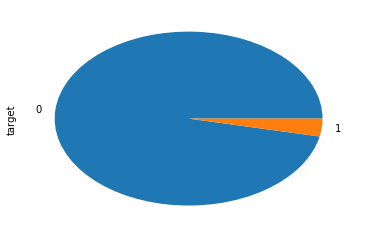

In [44]:
# RawData.target.value_counts.plot.pie()
#RawData.groupby(RawData.target).values_count().plot(kind='pie',subplots = True)
RawData['target'].value_counts().plot(kind = 'pie')
plt.show()
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

### This is an imbalanced dataset
- Under sampling to balance out the dataset

In [55]:
# Class count
count_class_0, count_class_1 = RawData.target.value_counts()

# Divide by class
df_class_0 = RawData[RawData['target'] == 0]
df_class_1 = RawData[RawData['target'] == 1]

Random under-sampling:
1    1653
0    1653
Name: target, dtype: int64


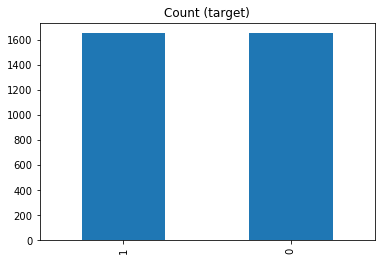

In [59]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');
plt.show()

In [60]:
x = df_test_under.iloc[:,0:102].values
y = df_test_under.iloc[:,102].values

### Scalling the data

In [61]:
min_max = MinMaxScaler()
x = min_max.fit_transform(x)

### Predicting target variables
- Using Kfold to make sure the models are not overfitting

In [63]:
num_instances = len(x)

models = []
models.append(('LiR', LogisticRegression()))
models.append(('Gradient', GradientBoostingClassifier()))
models.append(('Adaboost', AdaBoostClassifier()))
models.append(('Bag_Classifier', BaggingClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVC', SVC()))

# Evaluations
results = []
names = []
scoring = []

for name, model in models:
    # Fit the model
    model.fit(x, y)    
    predictions = model.predict(x) 
    # Evaluate the model
    kfold = cross_validation.KFold(n=num_instances, n_folds=10, random_state=7)
    cv_results = cross_validation.cross_val_score(model, x, y, cv=kfold,scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LiR: 0.506365 (0.028193)
Gradient: 0.536333 (0.038876)
Adaboost: 0.543277 (0.038257)
Bag_Classifier: 0.532902 (0.061176)
RandomForest: 0.531685 (0.069343)
DecisionTree: 0.533596 (0.031919)
KNN: 0.497267 (0.028806)


### Random forest has the least variability

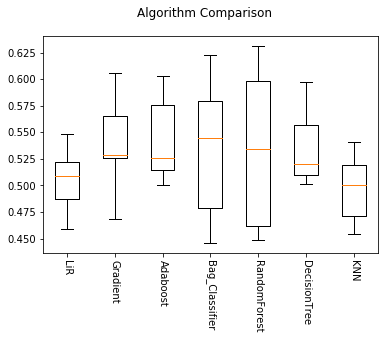

In [64]:
#boxplot algorithm Comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-90)
plt.show()

### Extracting feature importance
- Running a deision tree did not yield any actionable insight

In [65]:
ET = ExtraTreeClassifier()
ET.fit(x, y)
print(ET.feature_importances_)

[ 0.04164498  0.          0.01158548  0.00418292  0.03993476  0.
  0.00456076  0.00061531  0.0013678   0.00123655  0.00077099  0.00219462
  0.01143166  0.00874095  0.00240237  0.00391046  0.00396516  0.00449079
  0.00476754  0.01088763  0.00648141  0.          0.00145115  0.06019426
  0.00307475  0.          0.00360077  0.00458195  0.00114409  0.01134343
  0.          0.00017735  0.00105115  0.0100342   0.00615947  0.00337525
  0.00097888  0.00254032  0.00144723  0.00263024  0.00078209  0.01084168
  0.          0.00085204  0.00379383  0.00159623  0.00168199  0.03248656
  0.          0.00440227  0.02964818  0.02757459  0.01404645  0.00486872
  0.02050152  0.00170118  0.00076998  0.03075902  0.04499779  0.01166487
  0.0174251   0.05575786  0.00419345  0.011172    0.01036704  0.0415283
  0.00708179  0.00151522  0.00877831  0.00038766  0.00549683  0.02382843
  0.00232733  0.00567683  0.00210124  0.01233994  0.00134296  0.01048734
  0.0034895   0.00652931  0.0307758   0.          0.        

### PCA decomposition
- Since the number of variables are very high, we need to trim down the list for effecient model run

In [8]:
pca = PCA(n_components=102)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=102, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

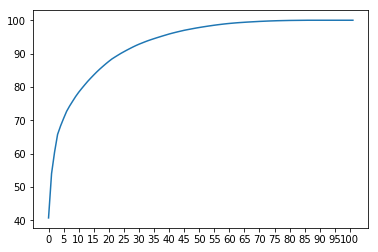

In [9]:
np.set_printoptions(suppress=True)
cum = np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
plt.plot(cum)
plt.xticks(np.arange(0, 102, 5))
plt.show()

In [78]:
#### Looking at above plot we can take 40 variables
pca = PCA(n_components=40)
trans = pca.fit(x)
x_trans = trans.transform(x)
#X_validation_trans = trans.transform(X_validation_std)

#### Classification with PCA 

In [79]:
num_instances = len(x)
model = RandomForestClassifier()
model.fit(x_trans, y)    
#predictions = model.predict(x) 
# Evaluate the model
kfold = cross_validation.KFold(n=num_instances, n_folds=10, random_state=7)
cv_results = cross_validation.cross_val_score(model, x_trans, y, cv=kfold,scoring = 'accuracy')


In [80]:
print(cv_results)
print("Overall Accuracy for Randon Tree:",cv_results.mean())


[ 0.52265861  0.53776435  0.55287009  0.55891239  0.56495468  0.38670695
  0.44242424  0.43636364  0.47272727  0.44242424]
Overall Accuracy for Randon Tree: 0.491780646343


## Predicting with Keras
- Multi output regression to predict both heating and cooling load simultaneously

In [81]:
# Creating Test and Training datat set 
X_train, X_test, y_train, y_test = train_test_split(x_trans,y, test_size = 0.2, random_state = 10)

In [68]:
x.shape

(3306, 102)

In [84]:
model = Sequential()
model.add(Dense(20, input_dim=40,activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(7, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.2))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# Fitting the model
clf_nn = model.fit(X_train,y_train,epochs=100,batch_size=50,validation_data=(X_test,y_test))

Train on 2644 samples, validate on 662 samples
Epoch 1/100
2644/2644 [==============================] - 2s 763us/step - loss: 2.3206 - acc: 0.4803 - val_loss: 0.6976 - val_acc: 0.4637
Epoch 2/100
2644/2644 [==============================] - 0s 62us/step - loss: 2.2455 - acc: 0.4977 - val_loss: 0.6939 - val_acc: 0.5166
Epoch 3/100
2644/2644 [==============================] - 0s 63us/step - loss: 2.2091 - acc: 0.4932 - val_loss: 0.6909 - val_acc: 0.5332
Epoch 4/100
2644/2644 [==============================] - 0s 64us/step - loss: 1.9981 - acc: 0.5148 - val_loss: 0.6873 - val_acc: 0.5574
Epoch 5/100
2644/2644 [==============================] - 0s 68us/step - loss: 2.1150 - acc: 0.5023 - val_loss: 0.6873 - val_acc: 0.5498
Epoch 6/100
2644/2644 [==============================] - 0s 92us/step - loss: 2.0453 - acc: 0.5072 - val_loss: 0.6864 - val_acc: 0.5468
Epoch 7/100
2644/2644 [==============================] - 0s 98us/step - loss: 2.0946 - acc: 0.5216 - val_loss: 0.6829 - val_acc: 0.5544


2644/2644 [==============================] - 0s 56us/step - loss: 2.0030 - acc: 0.6278 - val_loss: 0.6683 - val_acc: 0.5891
Epoch 61/100
2644/2644 [==============================] - 0s 75us/step - loss: 2.1671 - acc: 0.6271 - val_loss: 0.6678 - val_acc: 0.5982
Epoch 62/100
2644/2644 [==============================] - 0s 60us/step - loss: 2.1649 - acc: 0.6271 - val_loss: 0.6684 - val_acc: 0.5921
Epoch 63/100
2644/2644 [==============================] - 0s 62us/step - loss: 2.0718 - acc: 0.6301 - val_loss: 0.6660 - val_acc: 0.6088
Epoch 64/100
2644/2644 [==============================] - 0s 62us/step - loss: 2.1254 - acc: 0.6290 - val_loss: 0.6690 - val_acc: 0.5876
Epoch 65/100
2644/2644 [==============================] - 0s 61us/step - loss: 2.1937 - acc: 0.6286 - val_loss: 0.6710 - val_acc: 0.5846
Epoch 66/100
2644/2644 [==============================] - 0s 58us/step - loss: 2.0389 - acc: 0.6415 - val_loss: 0.6697 - val_acc: 0.5801
Epoch 67/100
2644/2644 [==============================

In [85]:
#from sklearn.metrics import r2_score

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print('Train r2: {:.2f}'.format(r2_score(y_train, y_train_predict)))
print('Test r2: {:.2f}'.format(r2_score(y_test, y_test_predict)))
#y_train_predict

Train r2: 0.16
Test r2: 0.04


In [86]:
scores = model.evaluate(X_train,y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2644/2644 [==============================] - 0s 53us/step

acc: 65.77%


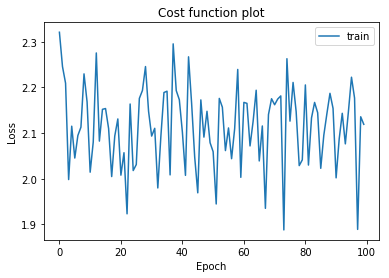

C:\Users\Airflowjhonson\AppData\Local\conda\conda\envs\6341\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "Lower right". Falling back on "best"; valid locations are
	right
	upper left
	lower left
	upper right
	center
	lower center
	lower right
	upper center
	center left
	center right
	best

  six.iterkeys(self.codes))))


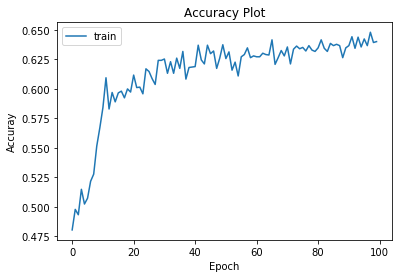

In [87]:
# Plotting the Cost Function - Loss 
plt.plot(clf_nn.history['loss'])
plt.title('Cost function plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plotting the accuracy 
plt.plot(clf_nn.history['acc'])
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuray')
plt.legend(['train', 'test'], loc='Lower right')
plt.show()

## Visualizing forecasts
Create a visualization (or set of visualizations) which compares the 2 forecasts so that the consumer of the visualization can determine which forecasting model is performing better.   

Assume that the consumer of the visualization is a non-technical marketing colleague without any data science training or background.

In [102]:
ForecastData = pd.read_csv("D:\\Box Sync\\University of Texas\\Summer Intern\\RAPP\\forecasts.csv",dtype={'actualsales': float})
#RawData.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height',
                   #  'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']
#print(RawData.head())
ForecastData.head()
ForecastData['date'] = pd.to_datetime(ForecastData['date'])
ForecastData['actualsales'] = ForecastData['actualsales'].astype(float)
ForecastData['championforecast'] = ForecastData['championforecast'].astype(float)
ForecastData['challengerforecast']=ForecastData['challengerforecast'].astype(float)

In [58]:
ForecastData[ForecastData['channel']=='Channel A'].head(30)

,date,market,channel,actualsales,challengerforecast,championforecast
0,2017-07-01,USA,Channel A,"3,773","3,226","3,877"
3,2017-08-01,USA,Channel A,"3,498","3,233","4,488"
6,2017-09-01,USA,Channel A,"3,175","3,340","3,824"
9,2017-10-01,USA,Channel A,"3,656","3,478","3,852"
12,2017-11-01,USA,Channel A,2883,"3,479",3646
15,2017-12-01,USA,Channel A,2833,"3,146",3336
18,2018-01-01,USA,Channel A,"3,794","3,319","3,834"
21,2018-02-01,USA,Channel A,"3,700","2,421","3,716"
24,2018-03-01,USA,Channel A,"3,737","3,700","3,332"
27,2018-04-01,USA,Channel A,"3,496","3,475","2,720"


In [155]:
def mean_absolute_percentage_error_champ(df): 
    y_true, y_pred = np.array(df['actualsales']), np.array(df['championforecast'])
    return 100- (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
def mean_absolute_percentage_error_chall(df): 
    y_true, y_pred = np.array(df['actualsales']), np.array(df['challengerforecast'])
    return 100-(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

In [119]:
groupped = ForecastData.groupby('channel')

In [106]:
ChannelA = ForecastData[ForecastData['channel'] == 'Channel A']
ChannelB = ForecastData[ForecastData['channel'] == 'Channel B']
ChannelC = ForecastData[ForecastData['channel'] == 'Channel C']

In [163]:
ChampMAPE =pd.DataFrame(groupped.apply(mean_absolute_percentage_error_champ))
ChampMAPE.columns = ['ChampMAPE']
ChampMAPE['channel'] = ChampMAPE.index
print(ChampMAPE)
ChallMAPE =pd.DataFrame(groupped.apply(mean_absolute_percentage_error_chall))
ChallMAPE.columns = ['ChallMAPE']
ChallMAPE['channel'] = ChallMAPE.index
print(ChallMAPE)
result =pd.concat([ChampMAPE,ChallMAPE],axis = 1,sort=False)
result


           ChampMAPE    channel
channel                        
Channel A  86.283492  Channel A
Channel B  90.909797  Channel B
Channel C  85.440370  Channel C
           ChallMAPE    channel
channel                        
Channel A  87.646458  Channel A
Channel B  87.637851  Channel B
Channel C  86.615010  Channel C


,ChampMAPE,channel,ChallMAPE,channel
channel,,,,
Channel A,86.283492,Channel A,87.646458,Channel A
Channel B,90.909797,Channel B,87.637851,Channel B
Channel C,85.440370,Channel C,86.615010,Channel C


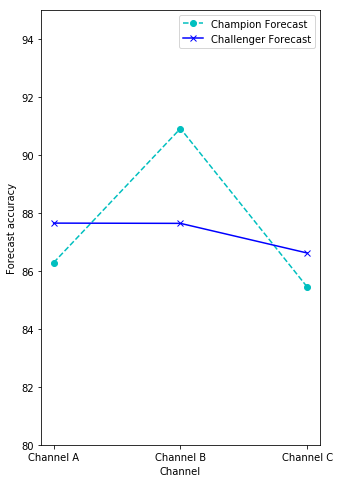

In [176]:
fig = plt.figure(figsize=(5,8))
ax1 = fig.add_subplot(111)
ax1.plot(result.index, result['ChampMAPE'], label='Champion Forecast', color='c', marker='o',linestyle = 'dashed')
ax1.plot(result.index, result['ChallMAPE'], label='Challenger Forecast', color='b', marker='x')
plt.ylabel('Forecast accuracy')
plt.xlabel('Channel')
plt.ylim(80,95)
plt.legend()
plt.show()